# **PREVISÕES USANDO MULTILAYER PERCEPTRON (MLP)**

## **<font color='orangered'>COM E SEM VALIDAÇÃO CRUZADA</font>**

In [1]:
# Pacotes necessários
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Base de dados

**Base de dados:** O blog *Cinetour - Viagem de Cinema* (https://www.cinetourviagemdecinema.com/).

**Período da série:** 01/06/2010 - 28/02/2023

In [2]:
VC = pd.read_csv('dados/VC-ST_mes.csv', sep=";", parse_dates=['Meses'], index_col=['Meses'])
VC.head()

,#Acessos
Meses,
2010-06-01,33
2010-07-01,244
2010-08-01,166
2010-09-01,196
2010-10-01,347


# **Modelos MLP**

## **<font color='orangered'>Parte 1: Usando 75% da base para treino e 25% para teste</font>**

- Reformulando os dados em uma matriz `n x (k + 1)`, onde `n` é o nº de amostras e `k` é o nº de características.

In [3]:
# Capturando um ciclo sazonal completo
k = 12

In [4]:
# As primeiras colunas de `Z` são os lags, e a última, o target
Z = []

for i in range(k + 1, VC.shape[0] + 1):
    Z.append(VC.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

Z.shape

(141, 13)

### Dados de Treino e de Teste

In [5]:
split = np.int(0.75 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

In [6]:
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

### **<font color='blue'>Treinamento SEM Validação Cruzada</font>**

In [7]:
split_ = np.int(0.75 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

def validation_loss(hidden_neurons):
        
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    
    mlp.fit(X_train_, y_train_)

    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [validation_loss(p) for p in params]

params[np.argmin(mse)]

20

In [8]:
mlp = MLPRegressor(hidden_layer_sizes=(20,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

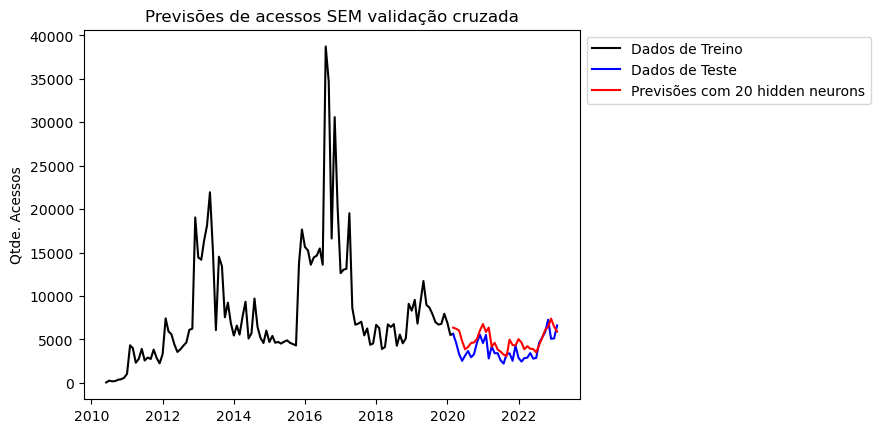

In [9]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos SEM validação cruzada')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 20 hidden neurons')
plt.legend(bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### **<font color='darkgreen'>Treinamento COM Validação Cruzada</font>**

In [10]:
tscv = TimeSeriesSplit(n_splits=5)

def cross_validation_loss(hidden_neurons):
    
    mse = []
    
    for train_split_, valid_split_ in tscv.split(X_train):
        
        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_] 
        
        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
        
        mlp.fit(X_train_, y_train_)
        
        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))
        
    return np.mean(mse)

In [11]:
params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [cross_validation_loss(p) for p in params]

params[np.argmin(mse)]

10

In [12]:
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred2 = mlp.predict(X_test)

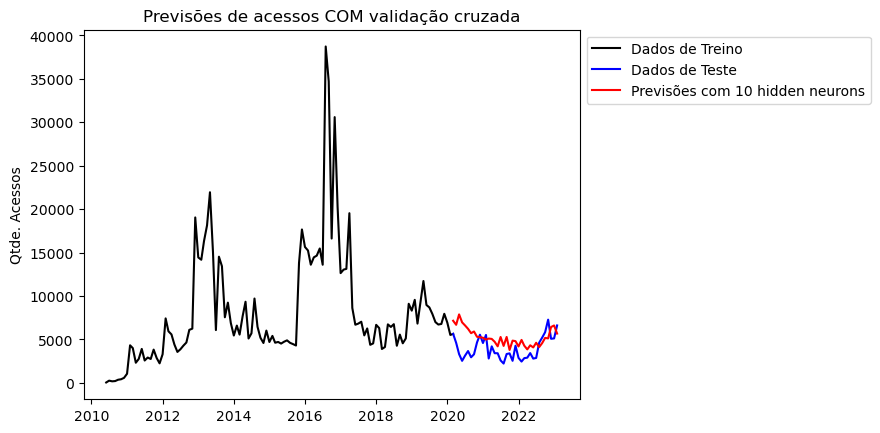

In [13]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred2.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos COM validação cruzada')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 10 hidden neurons')
plt.legend(bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Resultados (quanto menor o erro, melhor)

In [14]:
# MLP sem validação cruzada e com 20 hidden nodes:

# RMSE
print(round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
# MAPE direto
print(round(mean_absolute_percentage_error(y_test, y_pred), 4))

0.2213
0.2259


In [15]:
# MLP com validação cruzada e 10 hidden nodes:

# RMSE
print(round(np.sqrt(mean_squared_error(y_test, y_pred2)), 4))
# MAPE direto
print(round(mean_absolute_percentage_error(y_test, y_pred2), 4))

0.3079
0.3342


O modelo MLP sem validação cruzada apresentou melhores resultados do que o que recebeu validação cruzada.

## **<font color='orangered'>Parte 2: Usando 80% da base para treino e 20% para teste</font>**

In [16]:
split = np.int(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

In [17]:
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

### **<font color='blue'>Treinamento SEM Validação Cruzada</font>**

In [18]:
split_ = np.int(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

def validation_loss(hidden_neurons):
        
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    
    mlp.fit(X_train_, y_train_)

    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [validation_loss(p) for p in params]

params[np.argmin(mse)]

15

In [19]:
mlp = MLPRegressor(hidden_layer_sizes=(15,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

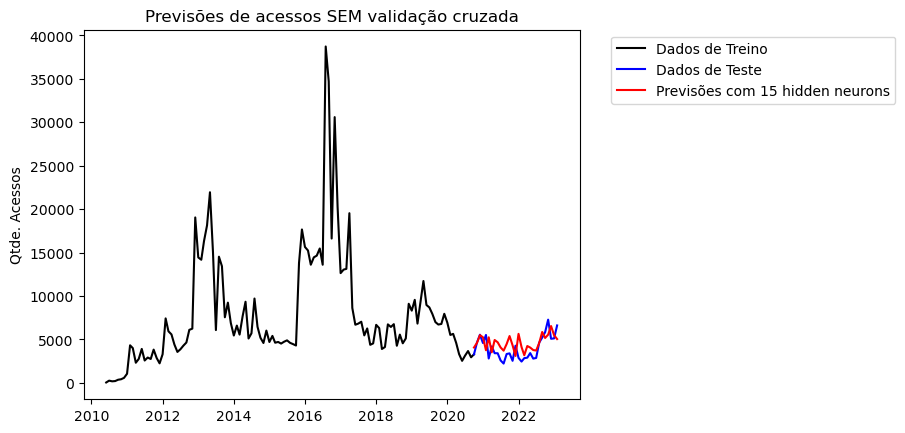

In [20]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos SEM validação cruzada')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 15 hidden neurons')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### **<font color='darkgreen'>Treinamento COM Validação Cruzada</font>**

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

def cross_validation_loss(hidden_neurons):
    
    mse = []
    
    for train_split_, valid_split_ in tscv.split(X_train):
        
        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_] 
        
        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
        
        mlp.fit(X_train_, y_train_)
        
        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))
        
    return np.mean(mse)

In [22]:
params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [cross_validation_loss(p) for p in params]

params[np.argmin(mse)]

10

In [23]:
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred2 = mlp.predict(X_test)

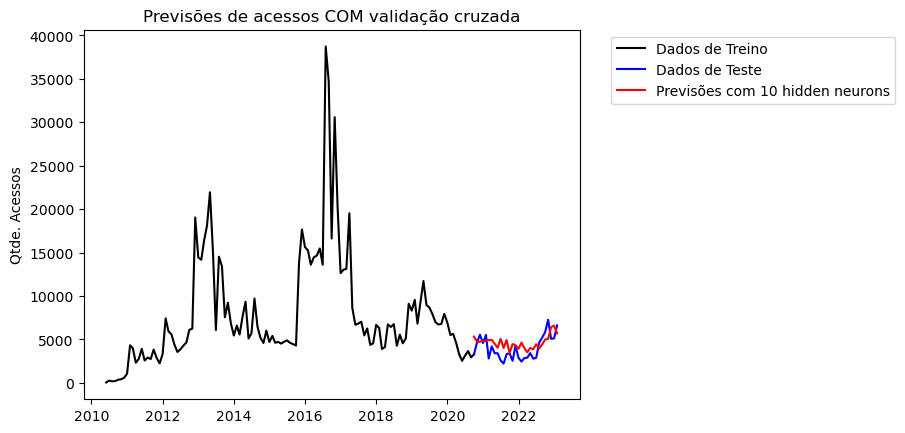

In [24]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred2.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos COM validação cruzada')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 10 hidden neurons')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Resultados (quanto menor o erro, melhor)

In [25]:
# MLP sem validação cruzada e com 15 hidden nodes:

# RMSE
print(round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
# MAPE direto
print(round(mean_absolute_percentage_error(y_test, y_pred), 4))

0.2124
0.2795


In [26]:
# MLP com validação cruzada e 10 hidden nodes:

# RMSE
print(round(np.sqrt(mean_squared_error(y_test, y_pred2)), 4))
# MAPE direto
print(round(mean_absolute_percentage_error(y_test, y_pred2), 4))

0.2105
0.2801


Os dois gráficos mostram que os dois modelos MLP apresentaram bons resultados.

 No entando, observando os valores de erros obtidos através das métricas, o primeiro modelo se destaca quando foi avaliado pelo MAPE (0.2795 contra 0.2801); e o segundo, quando foi medido pelo RMSE (0.2105 contra 0.2124).

### **<font color='orangered'>Conclusão deste experimento</font>**

Este experimento mostrou o quanto um aumento ou redução na base de treino e teste pode modificar o resultado de uma previsão.

Inicialmente, tanto o modelo com 75% da base sendo usada para treino como o que tem 80% da base para esse fim, quando usaram validação cruzada, encontraram o número ideal de 10 hidden neurons para fazerem as melhores previsões de acessos.

No entanto, foi o segundo modelo, com 80% da base destinada para treino, que encontrou a melhor estimativa; o seu RMSE foi de 0.2105 contra os 0.3079 daquele que tinha 5% menos base para treinamento.